In [1]:
import uproot as up
import awkward as ak
import pandas as pd
from scipy.optimize import curve_fit

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm, trange
import time
from pathlib import Path

import mplhep as hep
hep.style.use('ROOT')


In [22]:
class Analysis:
    '''
    This class fills a dictionary masks for testing various hit and event level cuts
    Includes a function to combine hit and event level cuts together 
    Returns the charges of the hits that pass all specified event and hit level cuts
    Also returns the number of hits taht pass all specified event and hit level cuts as a function of pmt id 
    '''
    
    def __init__(self, file_path, nevents=None):
        self.file_path = Path(file_path)
        self.nevents = nevents
        # Raw data 
        self.meta_data = None
        self.output_data = None
        self.waveform_data = None
        # Stuff to calculate 
        self.hit_time_res = None
        self.hit_tof = None
        self.low_energy_dt_new = None
        self.low_energy_dt_old = None
        self.coinc_hit_counts = None
        self.coinc_hit_err = None
        # PMT groupings
        self.pmt_channels = {}
        self.pmt_is_online = None
        # Cut masks 
        self.masks = {}  
        self.mask_type = {}
        
    def print_file_info(self):
        f = up.open(self.file_path)
        print(f"File: {self.file_path}")
        print(f"Loading: {self.nevents or 'all'} of {f['output'].num_entries} events")
        
    def load_meta_data(self):
        f = up.open(self.file_path)
        print(f"Meta Keys: {f['meta'].keys()}")
        start = time.time()
        self.meta_data = f['meta'].arrays([
            'pmtId', 'pmtChannel', 'pmtIsOnline',
            'pmtX', 'pmtY', 'pmtZ'
        ], entry_start=0, entry_stop=1, library='ak')
        stop = time.time()
        print(f"Loaded meta data in {stop-start:.2f} seconds")
        self.setup_pmt_channels()
     
    def load_event_data(self):
        f = up.open(self.file_path)
        print(f"Output Keys: {f['output'].keys()}")
        start = time.time()
        self.output_data = f['output'].arrays([
            'timestamp', 'triggerTime', 'timeSinceLastTrigger_us',
            'digitPMTID', 'digitTime', 'digitCharge', 'digitHitCleaningMask', 'digitNhits',
            'fit_time_Lognormal', 
            'x_quadfitter', 'y_quadfitter', 'z_quadfitter', 'time_quadfitter', 
            'validposition_quadfitter', 'validtime_quadfitter',
            'x_seedndestroy', 'y_seedndestroy', 'z_seedndestroy', 'time_seedndestroy', 
            'validposition_seedndestroy', 'validtime_seedndestroy'
        ], entry_start=0, entry_stop=self.nevents, library='ak')
        stop = time.time()
        print(f"Loaded event data in {stop-start:.2f} seconds")
    
    def load_waveforms(self):
        f = up.open(self.file_path)
        start = time.time()
        self.waveform_data = f['waveforms'].arrays([
            'evid', 
            'waveform_pmtid', 
            'inWindowPulseTimes', 
            'inWindowPulseCharges', 
            'waveform'
            ], entry_start=0, entry_stop=self.nevents, library='ak')
        stop = time.time()
        print(f"Loaded waveform data in {stop-start:.2f} seconds")
    
    def setup_pmt_channels(self):
        if self.meta_data is None:
            raise RuntimeError("Meta data must be loaded first")
        board_configs = {
            'barrel': [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11],
            'top': [12, 13],
            'dichroic': [7],
            'bottom': [14, 15],
            'behind': [16]  # only 13 channels 
        }
        for region, boards in board_configs.items():
            channels = []
            for board in boards:
                n_channels = 13 if (region == 'behind') else 16
                channels.extend([16 * board + i for i in range(n_channels)])
            self.pmt_channels[region] = channels
    
    def calculate_time_residuals(self, use_lognormal=True, use_snd=True):
        if self.output_data is None:
            raise RuntimeError("Event data must be loaded first")
        # Event fit results 
        if use_snd:
            event_time = self.output_data['time_seedndestroy']
            fitx = ak.broadcast_arrays(self.output_data['digitPMTID'], self.output_data['x_seedndestroy'])[1]
            fity = ak.broadcast_arrays(self.output_data['digitPMTID'], self.output_data['y_seedndestroy'])[1]
            fitz = ak.broadcast_arrays(self.output_data['digitPMTID'], self.output_data['z_seedndestroy'])[1]
            valid_fit = (self.output_data['validtime_seedndestroy'] & self.output_data['validposition_seedndestroy'])
        else:
            event_time = self.output_data['time_quadfitter']
            fitx = ak.broadcast_arrays(self.output_data['digitPMTID'], self.output_data['x_quadfitter'])[1]
            fity = ak.broadcast_arrays(self.output_data['digitPMTID'], self.output_data['y_quadfitter'])[1]
            fitz = ak.broadcast_arrays(self.output_data['digitPMTID'], self.output_data['z_quadfitter'])[1]
            valid_fit = (self.output_data['validtime_quadfitter'] & self.output_data['validposition_quadfitter'])
        # Hit results 
        if use_lognormal:
            hit_time = self.output_data['fit_time_Lognormal']
        else:
            hit_time = self.output_data['digitTime']
        event_time = ak.broadcast_arrays(hit_time, event_time)[1]
        # Get PMT positions
        pmtX = ak.Array(self.meta_data['pmtX'][0])
        pmtY = ak.Array(self.meta_data['pmtY'][0])
        pmtZ = ak.Array(self.meta_data['pmtZ'][0])
        # Map PMT positions to hits
        hitx_flat = pmtX[ak.flatten(self.output_data['digitPMTID'])]
        hity_flat = pmtY[ak.flatten(self.output_data['digitPMTID'])]
        hitz_flat = pmtZ[ak.flatten(self.output_data['digitPMTID'])]
        hitx = ak.unflatten(hitx_flat, ak.num(self.output_data['digitPMTID']))
        hity = ak.unflatten(hity_flat, ak.num(self.output_data['digitPMTID']))
        hitz = ak.unflatten(hitz_flat, ak.num(self.output_data['digitPMTID']))
        # Calculate time of flight
        dist = np.sqrt((fitx - hitx)**2 + (fity - hity)**2 + (fitz - hitz)**2)
        hit_tof = dist / 224  # speed of light in water [mm/ns]
        self.hit_tof = hit_tof
        # Calculate time residuals
        hit_time_res = hit_time - event_time - hit_tof
        valid_fit = ak.broadcast_arrays(hit_time, valid_fit)[1]
        self.hit_time_res = ak.where(valid_fit, hit_time_res, np.nan)
    
    def create_hit_amplitude_mask(self, mask_name='hit_amplitude'):
        mask = ((self.output_data['digitHitCleaningMask'] >> 1) & 1) == 0
        self.masks[mask_name] = mask
        self.mask_type[mask_name] = 'hit'
        return mask
    
    def create_hit_charge_mask(self, min_charge=0, mask_name='hit_charge'):
        charge = self.output_data['digitCharge']
        mask = charge > min_charge
        self.masks[mask_name] = mask
        self.mask_type[mask_name] = 'hit'
        return mask
    
    def create_hit_time_mask(self, time_range=(-10, 10), mask_name='hit_time'):
        if self.hit_time_res is None:
            raise RuntimeError("Time residuals must be calculated first")
        mask = ((self.hit_time_res > time_range[0]) & 
                (self.hit_time_res < time_range[1]))
        self.masks[mask_name] = mask
        self.mask_type[mask_name] = 'hit'
        return mask
    
    def create_fiducial_volume_mask(self, z_cut=600, r_cut=600, use_snd=True, mask_name='fiducial'):
        if use_snd:
            x_fit = self.output_data['x_seedndestroy']
            y_fit = self.output_data['y_seedndestroy'] 
            z_fit = self.output_data['z_seedndestroy']
            valid_fit = (self.output_data['validtime_seedndestroy'] & self.output_data['validposition_seedndestroy'])
        else:
            x_fit = self.output_data['x_quadfitter']
            y_fit = self.output_data['y_quadfitter']
            z_fit = self.output_data['z_quadfitter']
            valid_fit = (self.output_data['validtime_quadfitter'] & self.output_data['validposition_quadfitter'])
        mask = ((z_cut > z_fit) & (z_fit > -z_cut) & 
                (r_cut > np.sqrt(x_fit**2 + y_fit**2)) &
                valid_fit)
        self.masks[mask_name] = mask
        self.mask_type[mask_name] = 'event'
        return mask
    
    def calculate_nhits(self, hit_masks=None):
        charges = self.output_data['digitCharge']
        if hit_masks:
            combined_mask = self.combine_masks(hit_masks, mask_type='hit')
            charges = ak.mask(charges, combined_mask)
        return ak.count(charges, axis=1)
    
    # Masks based on nhit thresholds 
    def create_energy_masks(self, high_energy_min=125, low_energy_min=50, hit_masks=None, high_name='high_energy',low_name='low_energy'):
        nhits = self.calculate_nhits(hit_masks)
        high_energy_mask = nhits >= high_energy_min
        low_energy_mask = (nhits >= low_energy_min) & (nhits < high_energy_min)
        self.masks[high_name] = high_energy_mask
        self.mask_type[high_name] = 'event'
        self.masks[low_name] = low_energy_mask
        self.mask_type[low_name] = 'event'
        return high_energy_mask, low_energy_mask


    # Combine multiple masks of same type (hit or event) 
    def combine_masks(self, mask_names, mask_type=None):
        if not mask_names:
            return None
            
        if mask_type:
            for name in mask_names:
                if self.mask_type[name] != mask_type:
                    raise ValueError(f"Mask {name} is not of type {mask_type}")
                    
        combined = self.masks[mask_names[0]]
        for name in mask_names[1:]:
            combined = combined & self.masks[name]
        return combined
    
    def get_hit_charges(self, hit_masks=None, event_masks=None):
        charges = self.output_data['digitCharge']
        
        if hit_masks:
            hit_mask = self.combine_masks(hit_masks, mask_type='hit')
            charges = ak.mask(charges, hit_mask)
            
        if event_masks:
            event_mask = self.combine_masks(event_masks, mask_type='event')
            charges = charges[event_mask]
            
        return charges
    
    def get_nhits(self, hit_masks=None, event_masks=None):
        charges = self.get_hit_charges(hit_masks, event_masks)
        return ak.count(charges, axis=1)
    
    def compute_coincident_hits(self, hit_masks=None, event_masks=None, normalize_by_events=True):
        # Get PMT mappings
        pmt_ids = self.meta_data['pmtId'][0]
        pmt_chs = self.meta_data['pmtChannel'][0] 
        id2ch = dict(zip(pmt_ids, pmt_chs))
        ch2id = dict(zip(pmt_chs, pmt_ids))
        # Start with all PMT IDs
        clean_ids = self.output_data['digitPMTID']
        # Apply hit masks
        if hit_masks:
            hit_mask = self.combine_masks(hit_masks, mask_type='hit')
            clean_ids = clean_ids[hit_mask]
        # Apply event masks  
        if event_masks:
            event_mask = self.combine_masks(event_masks, mask_type='event')
            clean_ids = clean_ids[event_mask]
        nevents = len(clean_ids)
        # Count hits per channel
        flat_clean_ids = ak.to_numpy(ak.flatten(clean_ids))
        flat_clean_lcns = np.array([id2ch[id] for id in flat_clean_ids])
        pmt_hit_counts = np.bincount(flat_clean_lcns, minlength=np.max(pmt_chs)+1)
        if normalize_by_events and nevents > 0:
            self.coinc_hit_counts = pmt_hit_counts / nevents
            self.coinc_hit_err = np.sqrt(pmt_hit_counts) / nevents
        else:
            self.coinc_hit_counts = pmt_hit_counts
            self.coinc_hit_err = np.sqrt(pmt_hit_counts)
        # Update PMT online status
        active_lcns = np.nonzero(pmt_hit_counts)[0]
        active_ids = [ch2id[lcn] for lcn in active_lcns if lcn in ch2id]
        n_pmts = max(ch2id.values()) + 1
        self.pmt_is_online = np.zeros(n_pmts, dtype=bool)
        self.pmt_is_online[active_ids] = True
        return self.coinc_hit_counts, self.coinc_hit_err 
    
    def summary(self):
        print("\n--- Analysis Summary ---") 
        print(f"File: {self.file_path}")
        print(f"Events loaded: {self.nevents}")#{len(self.output_data['timestamp']) if self.output_data else 'None'}")
        print(f"\nMasks created: {len(self.masks)}")
        for name, type in self.mask_type.items():
            print(f"  {name}: {type}")
        print(f"\nStuff Calculated:")
        print(f"  Time residuals: {'Yes' if self.hit_time_res is not None else 'No'}")
        print(f"  Delayed times: {'Yes' if self.low_energy_dt is not None else 'No'}")
        print(f"  Coincident hits: {'Yes' if self.coinc_hit_counts is not None else 'No'}")
    
    def list_masks(self, mask_type=None):
        print("\n--- Available Masks ---") 
        for name, type in self.mask_type.items():
            if mask_type is None or type == mask_type:
                print(f"{name:20} ({type})")
                

In [23]:
file = '/nfs/disk1/users/bharris/eos/sim/EosSimulations/sr90.ntuple.root'


In [25]:
# Initialize and load data
run = Analysis(file, nevents=6335)

run.print_file_info()

run.load_meta_data()
run.load_event_data()
run.load_waveforms()

File: /nfs/disk1/users/bharris/eos/sim/EosSimulations/sr90.ntuple.root
Loading: 6335 of 6335 events
Meta Keys: ['runId', 'runType', 'runTime', 'dsentries', 'macro', 'pmtType', 'pmtId', 'pmtChannel', 'pmtIsOnline', 'pmtCableOffset', 'pmtChargeScale', 'pmtPulseWidthScale', 'pmtX', 'pmtY', 'pmtZ', 'pmtU', 'pmtV', 'pmtW', 'digitizerWindowSize', 'digitizerSampleRate_GHz', 'digitizerDynamicRange_mV', 'digitizerResolution_mVPerADC', 'calibId', 'calibMode', 'calibIntensity', 'calibWavelength', 'calibName', 'calibTime', 'calibX', 'calibY', 'calibZ', 'calibU', 'calibV', 'calibW', 'geo_index', 'geo_file', 'experiment', 'source_pos_x', 'source_pos_y', 'source_pos_z', 'source_rot_x', 'source_rot_y', 'source_rot_z']
Loaded meta data in 0.00 seconds
Output Keys: ['mcpdg', 'mcx', 'mcy', 'mcz', 'mcu', 'mcv', 'mcw', 'mcke', 'mct', 'evid', 'subev', 'nhits', 'triggerTime', 'timestamp', 'trigger_word', 'event_cleaning_word', 'timeSinceLastTrigger_us', 'mcid', 'mcparticlecount', 'mcpecount', 'mcnhits', 'sci

In [ ]:
run.create_hit_amplitude_mask()
run.create_hit_charge_mask(min_charge=0)
run.calculate_time_residuals(use_lognormal=True,use_snd=True)
time_range = (-5,5)
run.create_hit_time_mask(time_range=time_range);

In [ ]:
for mask in run.masks:
    print(mask)



hit_amplitude
hit_charge
hit_time


Text(1, 0, 'Time (ns)')

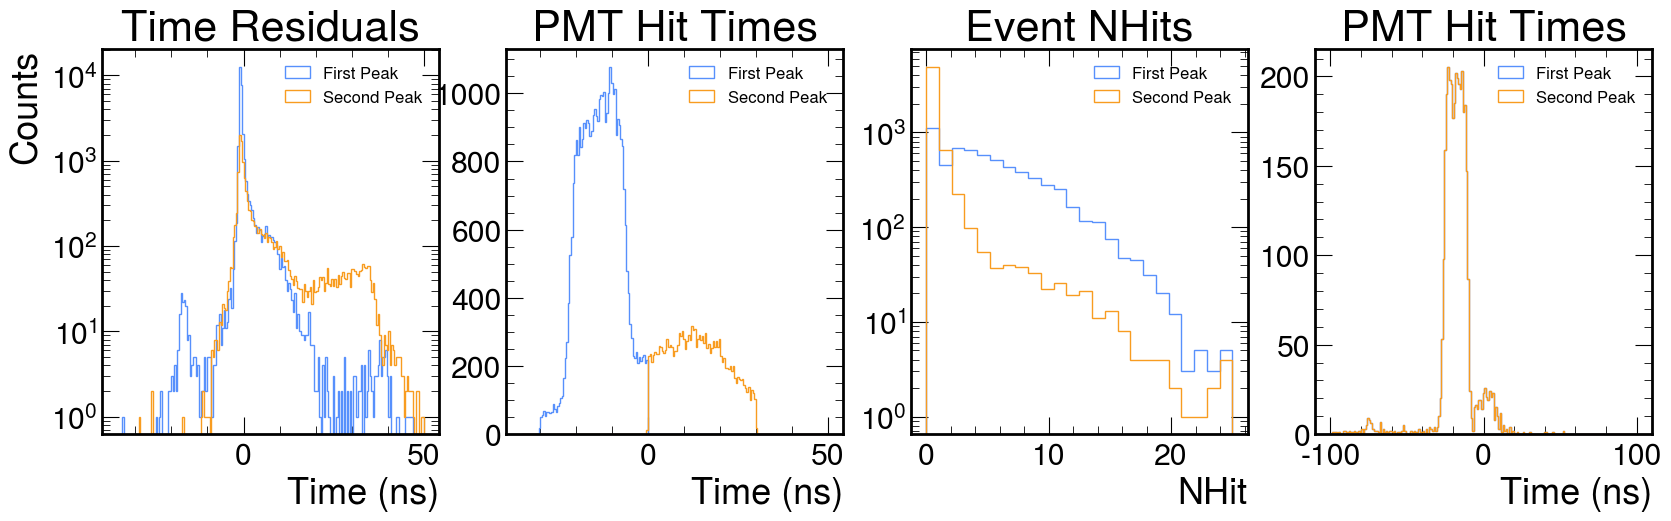

In [ ]:
ht  = run.output_data['fit_time_Lognormal']
first = (-30<ht) & (ht<0)
second = (0<ht) & (ht<30)

trigtime = run.output_data['time_seedndestroy']
tres = run.hit_time_res

edges = np.linspace(-35,50,200)
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].hist(ak.flatten(tres[first]),edges,histtype='step',label='First Peak');
ax[0].hist(ak.flatten(tres[second]),edges,histtype='step',label='Second Peak');
ax[0].set_title('Time Residuals')
ax[0].set_xlabel('Time (ns)')
ax[0].set_ylabel('Counts')
ax[0].set_yscale('log')
ax[0].legend(fontsize=12)

ax[1].hist(ak.flatten(ht[first]),edges,histtype='step',label='First Peak')
ax[1].hist(ak.flatten(ht[second]),edges,histtype='step',label='Second Peak');
ax[1].legend(loc='upper right',fontsize=12)
ax[1].set_title('PMT Hit Times')
ax[1].set_xlabel('Time (ns)')
# ax[1].set_ylabel('Counts')

edges2 = np.linspace(0,25,25)
ax[2].hist(ak.count(ht[first],axis=1),edges2,histtype='step',label='First Peak')
ax[2].hist(ak.count(ht[second],axis=1),edges2,histtype='step',label='Second Peak');
ax[2].legend(loc='upper right',fontsize=12)
ax[2].set_title('Event NHits')
ax[2].set_xlabel('NHit')
ax[2].set_yscale('log')





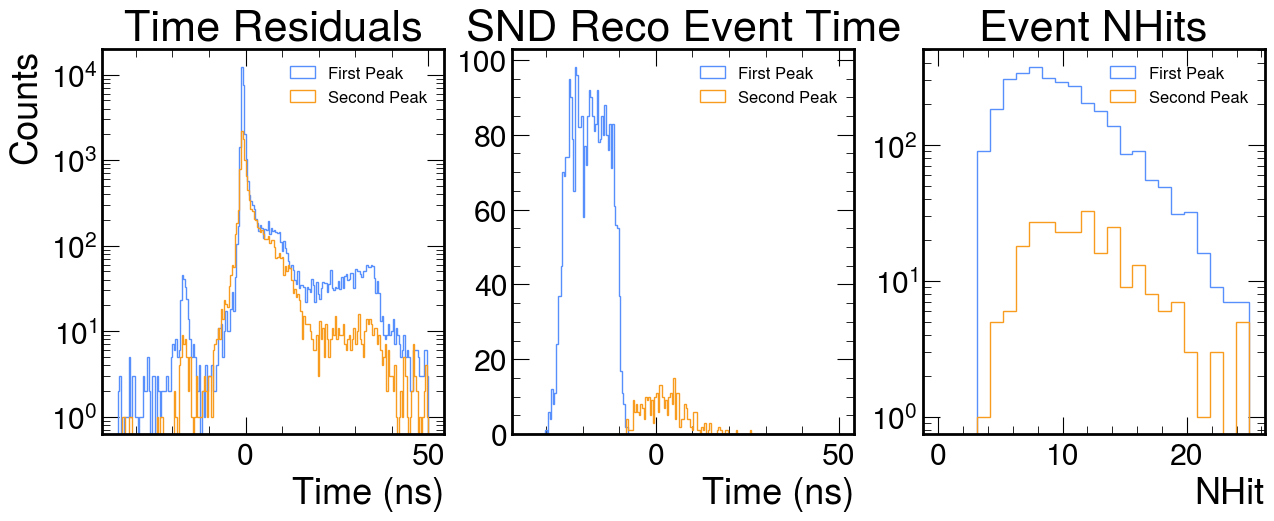

In [118]:
ht  = run.output_data['fit_time_Lognormal']
trigtime = run.output_data['time_seedndestroy']
first = (-30<trigtime) & (trigtime<-8)
second = (-8<trigtime) & (trigtime<30)

tres = run.hit_time_res

edges = np.linspace(-35,50,200)
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].hist(ak.flatten(tres[first]),edges,histtype='step',label='First Peak');
ax[0].hist(ak.flatten(tres[second]),edges,histtype='step',label='Second Peak');
ax[0].set_title('Time Residuals')
ax[0].set_xlabel('Time (ns)')
ax[0].set_ylabel('Counts')
ax[0].set_yscale('log')
ax[0].legend(fontsize=12)

ax[1].hist(trigtime[first],edges,histtype='step',label='First Peak')
ax[1].hist(trigtime[second],edges,histtype='step',label='Second Peak');
ax[1].legend(loc='upper right',fontsize=12)
ax[1].set_title('SND Reco Event Time')
ax[1].set_xlabel('Time (ns)')
# ax[1].set_ylabel('Counts')

edges2 = np.linspace(0,25,25)
ax[2].hist(ak.count(ht[first],axis=1),edges2,histtype='step',label='First Peak')
ax[2].hist(ak.count(ht[second],axis=1),edges2,histtype='step',label='Second Peak');
ax[2].legend(loc='upper right',fontsize=12)
ax[2].set_title('Event NHits')
ax[2].set_xlabel('NHit')
ax[2].set_yscale('log')
